In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations

from sklearn import metrics
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import ensemble
from sklearn import model_selection
from sklearn import pipeline
from sklearn import mixture
from sklearn import svm
from sklearn import neighbors
from sklearn import feature_selection
from sklearn import naive_bayes
from sklearn import discriminant_analysis
from sklearn import tree

%matplotlib inline

### Loading training and testing dataset

In [2]:
train_df = pd.read_csv('datasets/ghosts/train.csv', usecols=range(1, 7))
test_df = pd.read_csv('datasets/ghosts/test.csv')

train_df.head()

,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [3]:
test_df.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color
0,3,0.471774,0.387937,0.706087,0.698537,black
1,6,0.427332,0.645024,0.565558,0.451462,white
2,9,0.549602,0.491931,0.660387,0.449809,black
3,10,0.638095,0.682867,0.471409,0.356924,white
4,13,0.361762,0.583997,0.377256,0.276364,black


In [4]:
print 'training shape:', train_df.shape
print 'testing shape:', test_df.shape

training shape: (371, 6)
testing shape: (529, 6)


### Exploring dataset

#### Checking missing value

In [5]:
train_df.isnull().sum()

bone_length      0
rotting_flesh    0
hair_length      0
has_soul         0
color            0
type             0
dtype: int64

#### Checking summary statistics

In [6]:
train_df.describe()

,bone_length,rotting_flesh,hair_length,has_soul
count,371.000000,371.000000,371.000000,371.000000
mean,0.434160,0.506848,0.529114,0.471392
std,0.132833,0.146358,0.169902,0.176129
min,0.061032,0.095687,0.134600,0.009402
25%,0.340006,0.414812,0.407428,0.348002
50%,0.434891,0.501552,0.538642,0.466372
75%,0.517223,0.603977,0.647244,0.600610
max,0.817001,0.932466,1.000000,0.935721


#### Checking distributions

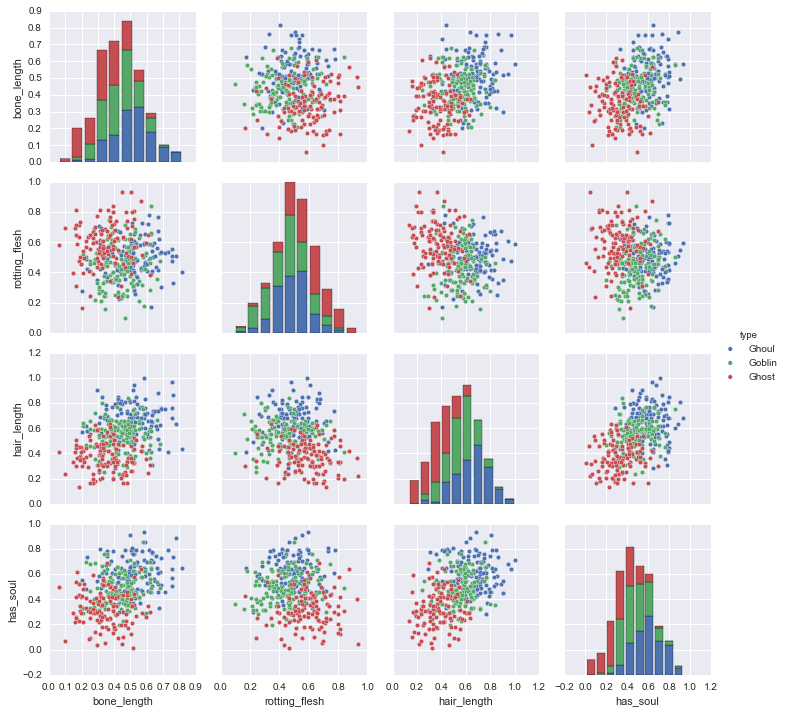

In [7]:
sns.pairplot(train_df, hue='type')

#### Checking distribution for numerical features

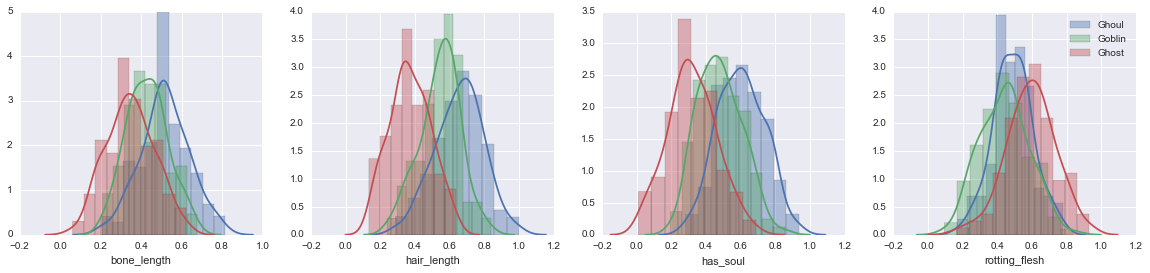

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
for i, feature in enumerate(['bone_length', 'hair_length', 'has_soul', 'rotting_flesh']):
    for label in train_df['type'].unique():
        d = train_df
        d = d[d['type'] == label]

        sns.distplot(d[feature], ax=axes[i], label=label)
        
plt.legend()

#### Checking correlations

In [9]:
train_df.corr()

,bone_length,rotting_flesh,hair_length,has_soul
bone_length,1.000000,-0.041716,0.353881,0.381675
rotting_flesh,-0.041716,1.000000,-0.220353,-0.132051
hair_length,0.353881,-0.220353,1.000000,0.474835
has_soul,0.381675,-0.132051,0.474835,1.000000


#### Checking outliers

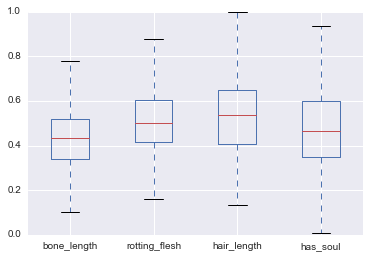

In [10]:
ax = train_df.boxplot(return_type='dict')

#### Checking categorical variable

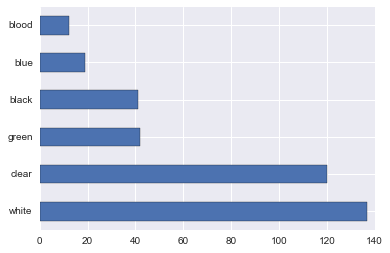

In [11]:
train_df['color'].value_counts().plot(kind='barh')

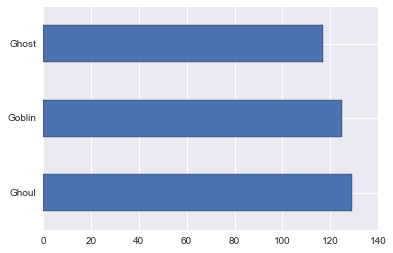

In [12]:
train_df['type'].value_counts().plot(kind='barh')

### Preparing datasets for model

#### Create features and label

In [13]:
X_train, y_train = train_df.drop(['type'], axis=1).copy(), train_df['type'].copy()
X_test = test_df.drop('id', axis=1).copy()

#### Transform categorical label to numerical using label encoding.

In [14]:
le_label = preprocessing.LabelEncoder()

y_train = le_label.fit_transform(y_train)

In [15]:
X_train = pd.concat([X_train.drop('color', axis=1), pd.get_dummies(X_train['color'])], axis=1)
X_test = pd.concat([X_test.drop('color', axis=1), pd.get_dummies(X_test['color'])], axis=1)

#### Feature creation

In [16]:
for features in combinations(train_df.columns[:4], 2):
    key = '{}_{}'.format(features[0], features[1])
    X_train[key] = X_train[features[0]] * X_train[features[1]]
    X_test[key] = X_test[features[0]] * X_test[features[1]]

In [17]:
for power in range(2, 15):
    for feature in train_df.columns[:4]:
        X_train['{}_power_{}'.format(feature, power)] = np.power(X_train[feature], power)
        X_test['{}_power_{}'.format(feature, power)] = np.power(X_test[feature], power)

In [18]:
for feature in train_df.columns[:4]:
    X_train['{}_sqrt'.format(feature, power)] = np.sqrt(X_train[feature])
    X_test['{}_sqrt'.format(feature, power)] = np.sqrt(X_test[feature])

In [19]:
X_train.shape

(371, 72)

#### Feature selection

In [20]:
selector = feature_selection.RFECV(ensemble.RandomForestClassifier(), step=1, cv=10, scoring='accuracy').fit(X_train, y_train)
selector

RFECV(cv=10,
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

In [21]:
X_train = X_train.loc[:, selector.support_]
X_test = X_test.loc[:,selector.support_]

In [22]:
X_train.shape

(371, 68)

### Selecting model

In [23]:
models = [
    ('lr', linear_model.LogisticRegression()),
    ('lda', discriminant_analysis.LinearDiscriminantAnalysis()),
    ('qda', discriminant_analysis.QuadraticDiscriminantAnalysis()),
    ('knn', neighbors.KNeighborsClassifier()),
    ('tree', tree.DecisionTreeClassifier()),
    ('svc', svm.SVC()),
    ('svc_linear', svm.LinearSVC()),
    ('ada', ensemble.AdaBoostClassifier()),
    ('extra', ensemble.ExtraTreesClassifier()),
    ('forest', ensemble.RandomForestClassifier()),
    ('nu_svc', svm.NuSVC())
]

In [24]:
cross_validation_scores = []
model_names = map(lambda x: x[0], models)

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=2016)
    cross_scores = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    cross_validation_scores.append(cross_scores)

/usr/local/lib/python2.7/dist-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python2.7/dist-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [25]:
resulf_df = pd.DataFrame(cross_validation_scores)
resulf_df['model_type'] = model_names
resulf_df = resulf_df.set_index('model_type')
resulf_df['mean'] = resulf_df.mean(axis=1)
resulf_df['std'] = resulf_df.std(axis=1)
resulf_df.sort_values('mean', ascending=False).T

model_type,lr,nu_svc,svc_linear,forest,qda,extra,lda,svc,knn,ada,tree
0,0.789474,0.710526,0.736842,0.657895,0.763158,0.578947,0.631579,0.710526,0.710526,0.605263,0.605263
1,0.729730,0.756757,0.648649,0.729730,0.675676,0.729730,0.702703,0.702703,0.675676,0.648649,0.594595
2,0.810811,0.756757,0.783784,0.810811,0.810811,0.783784,0.783784,0.783784,0.729730,0.783784,0.648649
3,0.702703,0.702703,0.675676,0.702703,0.675676,0.675676,0.648649,0.621622,0.621622,0.540541,0.567568
4,0.837838,0.783784,0.810811,0.783784,0.756757,0.702703,0.756757,0.702703,0.810811,0.675676,0.540541
5,0.756757,0.783784,0.756757,0.648649,0.810811,0.702703,0.648649,0.702703,0.702703,0.729730,0.702703
6,0.729730,0.702703,0.702703,0.756757,0.702703,0.702703,0.702703,0.702703,0.675676,0.675676,0.648649
7,0.675676,0.756757,0.675676,0.729730,0.675676,0.729730,0.729730,0.729730,0.594595,0.675676,0.540541
8,0.864865,0.756757,0.837838,0.729730,0.729730,0.783784,0.783784,0.702703,0.756757,0.594595,0.648649
9,0.675676,0.621622,0.648649,0.675676,0.486486,0.594595,0.567568,0.567568,0.513514,0.594595,0.486486


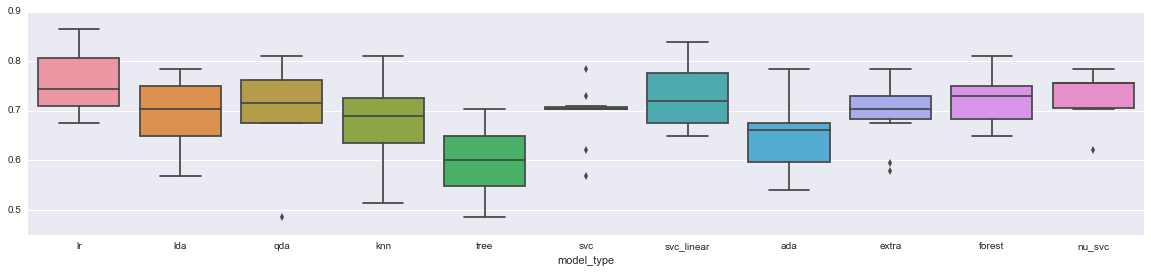

In [31]:
plt.figure(figsize=(20, 4))
sns.boxplot(resulf_df.drop(['mean', 'std'], axis=1).T)

### Hiperparameters tuning

In [27]:
params = {
    'C': np.linspace(0.0001, 2, 5),
    'class_weight': [None, 'balanced'],
    'multi_class': ['ovr', 'multinomial'],
    'solver': ['newton-cg']
}


model = model_selection.GridSearchCV(linear_model.LogisticRegression(), params, scoring='accuracy', cv=10)
model.fit(X_train, y_train)

print 'best score:', model.best_score_
print 'params:', model.best_params_

best score: 0.749326145553
params: {'multi_class': 'ovr', 'C': 1.5000249999999999, 'solver': 'newton-cg', 'class_weight': None}


### Evaluating models

#### Classification report

In [28]:
y_pred = model.predict(X_train)
print metrics.classification_report(y_train, y_pred)

             precision    recall  f1-score   support

          0       0.83      0.91      0.87       117
          1       0.79      0.80      0.79       129
          2       0.70      0.62      0.66       125

avg / total       0.77      0.77      0.77       371



#### Confusion matrixies

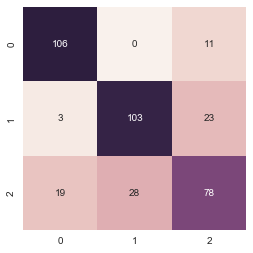

In [29]:
conf_matrix = metrics.confusion_matrix(y_train, y_pred)
ax = sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cbar=False)

# Saving prediction

In [30]:
predictions_df = test_df[['id']]
predictions_df.ix[:, 'type'] = le_label.inverse_transform(prepared_models['lr'].predict(X_test))

NameError: name 'prepared_models' is not defined

In [ ]:
predictions_df.to_csv('ghost_predictions.csv', index=False)